<a href="https://www.kaggle.com/code/pyagoubi/amex-eda-evolvement-of-numeric-features-over-time?scriptVersionId=104531331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook displays the evolvement of numeric features over time for both classes.

References  
-https://www.kaggle.com/code/pavelvod/amex-eda-even-more-insane-time-patterns-revealed  
-https://www.kaggle.com/code/pavelvod/amex-eda-revealing-time-patterns-of-features/notebook


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
#from colorama import Fore, Back, Style
from scipy.stats import gmean
from datetime import datetime, timedelta
import seaborn as sns
import math


In [2]:
train = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
#test = pd.read_feather('test_data.ftr')

target = pd.read_csv("../input/amex-default-prediction/train_labels.csv")


bin_cols = ['B_31', 'D_87']
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
num_cols = list(set(train.columns)-set(cat_cols+['S_2', 'customer_ID']))


train['S_2'] = pd.to_datetime(train['S_2'])
train['S_2_max'] = train[['S_2','customer_ID']].groupby('customer_ID').S_2.transform('max')
train['S_2_min'] = train[['S_2','customer_ID']].groupby('customer_ID').S_2.transform('min')
#train['S_2_diff'] = train[['S_2','customer_ID']].groupby('customer_ID').S_2.transform('diff').dt.days
train['S_2_d'] = (train['S_2_max']-train['S_2']).dt.days
#train['S_2_m'] = round((train['S_2']-train['S_2_min'])/np.timedelta64(1, 'M'), 0)
train['S_2_m'] = (train['S_2']-train['S_2_min'])
train['S_2_m'] = train[['S_2_m','customer_ID']].groupby('customer_ID').rank()

train = pd.merge(train, target, on='customer_ID', how ='left')
train.sort_values(['customer_ID', 'S_2_d'],  ascending = [True, False], inplace = True)


We will only check for those creditors that provided 13 statements, hence were present during the whole time period.

In [3]:
df_presence = train.groupby(['customer_ID']).size().reset_index().rename(columns={0:'presence'})
df_presence

,customer_ID,presence
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13
...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,13
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,13
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,13
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,13


In [4]:
train = pd.merge(train, df_presence, on='customer_ID', how ='left')

Records are aggregated on month level and plotted seperately for defaulting and non-defaulting (performing) customers

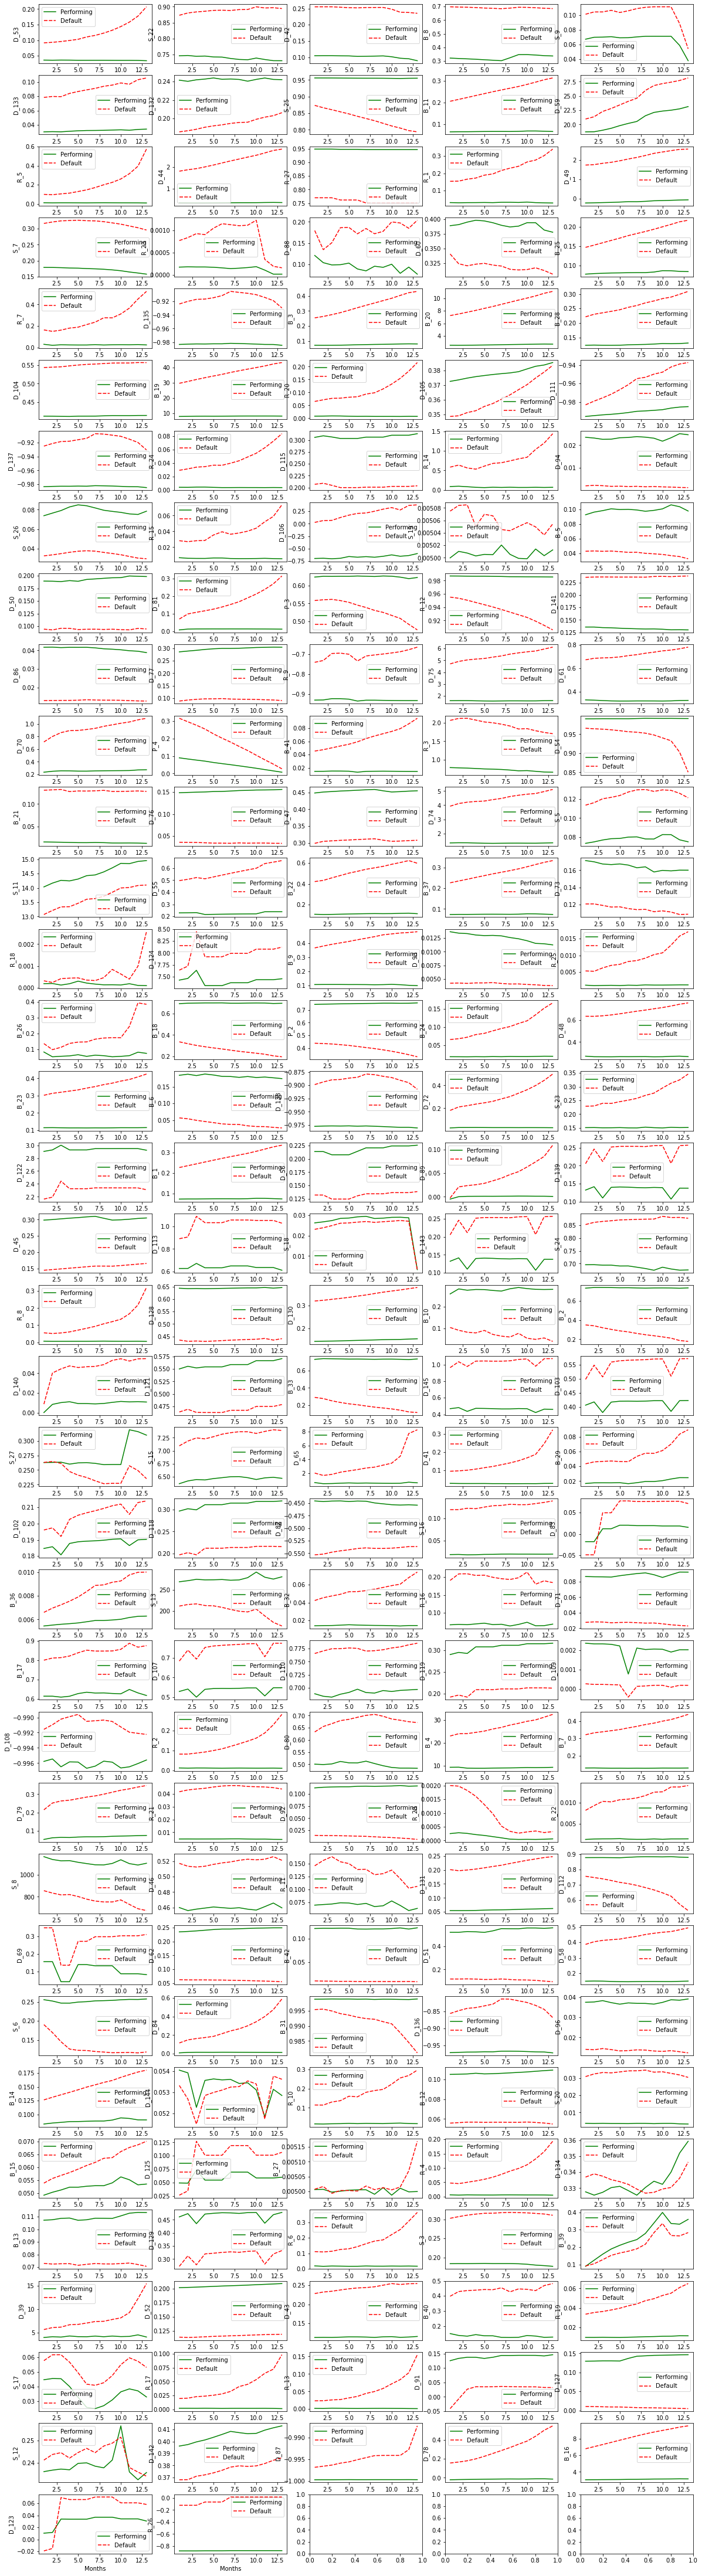

In [5]:


i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(math.ceil(len(num_cols)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 80))
for col in num_cols:
  temp1 = train[(train['target']==0) & (train['presence']==13)].groupby('S_2_m')[col].mean().reset_index().set_index('S_2_m')
  temp2 = train[(train['target']==1) & (train['presence']==13)].groupby('S_2_m')[col].mean().reset_index().set_index('S_2_m')
  temp1.columns= ['Performing']
  temp2.columns= ['Default']
  sns.lineplot(data = pd.merge(temp1, temp2, on = 'S_2_m'), palette = ['green', 'red'], ax=axs[i][j])
  axs[i][j].set(xlabel='Months',
       ylabel=col)
  j+=1
  if j%PLOTS_PER_ROW==0:
    i+=1
    j=0
plt.show()







Insight
- not only levels but also growth rates are very differnt for both classes, giving nice new features